In [10]:
library(dplyr)
library(tibble)
library(reshape2)
library(xtable)

library(RColorBrewer)
library(ggplot2)
library(cowplot)

theme_set(theme_bw())


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [63]:
source("../R/calc.R")
source("../R/misc.R")
source("../R/normalise.R")
source("../R/plot.R")
source("../R/predict.R")
source("../R/subset.R")
source("../R/utils.R")

## Import data

In [4]:
### ANNOTATIONS
METADATA_SID <- "../data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "../data/GSE67684/processed/metadata/pid-metadata_v7.tsv"

metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')
metadata_pid$label <- as.factor(metadata_pid$label)

### DATA
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "../data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


### Commonly used globals

#### All train set (incl. hyperdiploid, others)
- For feature investigation. Remove hypodiploid
- Not required in code!

#### All train set (excl. hyperdiploid, others)
- Does not contain heterogeneous subtypes and MRD NA samples

#### Train/test split (excl. hyperdiploid, others)
- Test set does not contain heterogeneous subtypes and MRD NA samples
- Training set should have the same distribution as test set

In [5]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]
heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

### Train/test split: Patients distribution

In [379]:
# # TODO: Do not evaluate to heterogeneous subtypes
# train_distr <- table(
#   Y[sid_train, "subtype"],
#   Y[sid_train, "label"]
# )/2
# test_distr <- table(
#   Y[sid_test, "subtype"],
#   Y[sid_test, "label"]
# )/2

# # # Transfer all relapse samples to test set
# # test_distr[, 2]<- test_distr[, 2] + train_distr[, 2]
# # train_distr[, 2] <- 0

# print(xtable(train_distr, display = rep("d", 3)))
# print(xtable(test_distr, display = rep("d", 3)))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed May 26 00:37:42 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   4 &   5 \\ 
  E2A-PBX1 &   3 &   0 \\ 
  Hyperdiploid &   0 &   0 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   2 &   2 \\ 
  Normal &   0 &   0 \\ 
  Others &   0 &   0 \\ 
  T-ALL &   7 &   1 \\ 
  TEL-AML1 &  20 &   4 \\ 
   \hline
\end{tabular}
\end{table}
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed May 26 00:37:42 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   1 &   0 \\ 
  E2A-PBX1 &   2 &   1 \\ 
  Hyperdiploid &   0 &   0 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   1 &   2 \\ 
  Normal &   0 &   0 \\ 
  Others &   0 &   0 \\ 
  T-ALL &   1 &   1 \\ 
  TEL-AML1 &   9 &   1 \\ 
   \hline
\end{tabular}
\end{table}


## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch genes

Constant: Timepoint, subtype , remission

In [6]:
batch_ps <- identify_batch_features(yeoh, metadata, method = 'aov')
length(batch_ps)

[1] "No. of NaNs = 0"


[1] 2565

### Drug genes

Constant: Subtype, remission

### M1: Entire data

In [7]:
# list_subtype_sids <- lapply(
#   subtypes7,
#   function(subtype) {
#     sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]
#   }
# )

In [38]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
list_obj <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps
)
names(list_obj) <- subtypes7

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
No. of features selected = 21
No. of final genes = 14
No. of samples in centroid = 5
No. of remission samples in training set = 5
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
No. of features selected = 239
No. of final genes = 164
No. of samples in centroid = 5
No. of remission samples in training set = 5
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 718"
[1] "No. of features (p-value) = 2508"
[1] "No. of features (log2-fc) = 283"
No. of features selected = 281
No. of final genes = 216
No. of samples in centroid = 31
No. of remission samples in training set = 31
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"

### Plot boxplots (comparing labels)

In [39]:
list_X_y <- lapply(list_obj, function(obj) obj$X_y)
boxplots <- lapply(list_X_y, plot_boxplots)

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message 

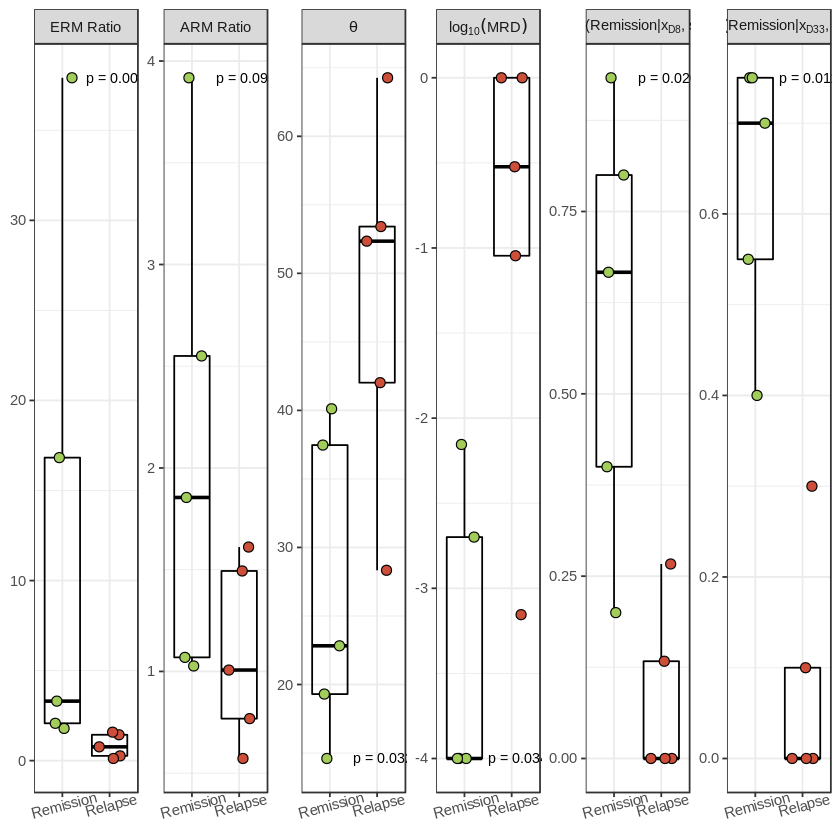

In [40]:
boxplots[[1]]

### Plot boxplots (comparing treatments)

In [41]:
list_X_y1 <- lapply(
  list_obj,
  function(obj) cbind(obj$X_y, metadata_pid[rownames(obj$X_y), "treatment", drop = FALSE])
)
boxplots_treatment <- lapply(list_X_y1, plot_boxplots_v2, colour_by = "treatment", shape_by = "label")

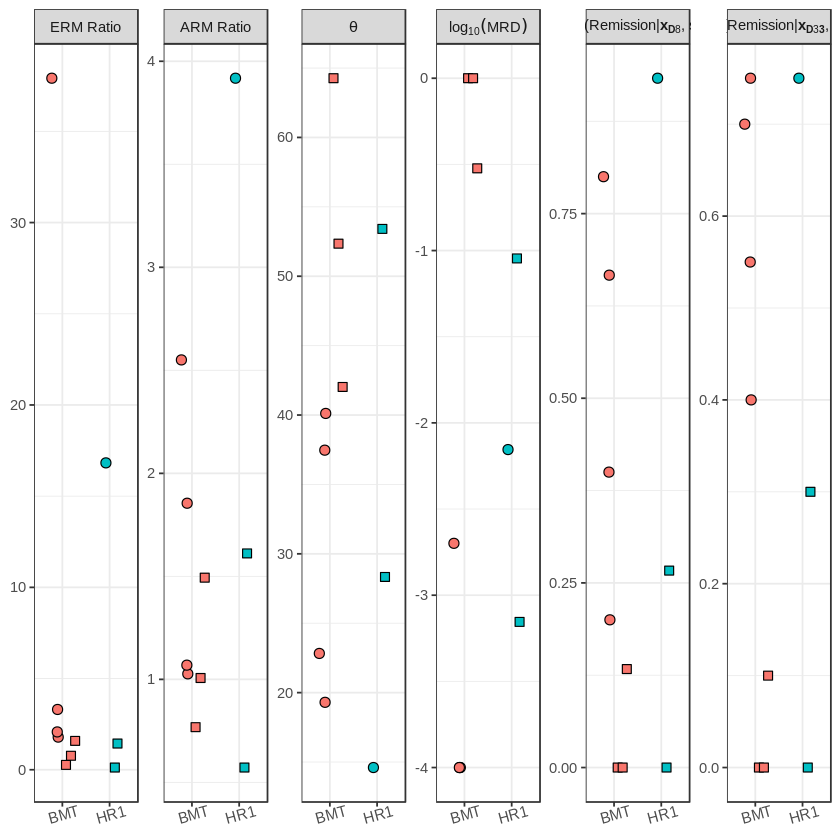

In [42]:
boxplots_treatment[[1]]

### Save probabilities

In [103]:
list_p_d8 <- lapply(list_obj, function(obj) obj$X_y["p_d8"])
p_d8 <- do.call(rbind, unname(list_p_d8))

In [104]:
list_p_d33 <- lapply(list_obj, function(obj) obj$X_y["p_d33"])
p_d33 <- do.call(rbind, unname(list_p_d33))

In [ ]:
# write.table(p_d8, "../tmp/p_d8.tsv", quote = F, sep = "\t")
# write.table(p_d33, "../tmp/p_d33.tsv", quote = F, sep = "\t")

#### Estimate probability using simulated samples
- Features are modelled as normal distributions (median, sd)

In [338]:
# list_obj2 <- lapply(
#   list_X_subtypes7,
#   predict_pipeline,
#   X_normal,
#   metadata, metadata_pid,
#   batch_ps,
#   samples = 300
# )
# names(list_obj2) <- subtypes7

In [98]:
# boxplots <- lapply(list_obj1, function(obj) plot_boxplots(obj$X_y))

# for (i in seq_len(length(subtypes7))) {
#   wpath <- sprintf("~/Dropbox/tmp/features_alltrain_simulated-%s.pdf", subtypes7[i])
#   ggsave(wpath, boxplots[[i]], width = 9, height = 2.5)
# }

In [99]:
# for (i in seq_len(length(subtypes7))) {
#   wpath <- sprintf("~/Dropbox/tmp/features_treatment-%s.pdf", subtypes7[i])
#   ggsave(wpath, boxplots[[i]], width = 9, height = 2.5)
# }

### Overall ROC
- Estimating probability of remission by calculating percentage of samples in training set with a worse score
- Subtype specific model during estimation
- Combine probability predictions into an overall ROC curve

### M1: Train/test

### M1: Test set 1 (w/o Hyp, Others)

In [56]:
names(list_X_subtypes7) <- subtypes7
list_X_subtypes5 <- list_X_subtypes7[subtypes5]

In [78]:
list_train_test <- lapply(
  list_X_subtypes5,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps,
  sid_train_test = list(sid_train, sid_test)
)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 760
No. of features (p-value) = 132
No. of features (log2-fc) = 326
No. of DE features = 24
No. of final features = 18
No. of samples in centroid = 5
No. of remission samples in training set = 4
No. of remission samples in training set = 4
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 1105
No. of features (p-value) = 356
No. of features (log2-fc) = 813
No. of DE features = 123
No. of final features = 79
No. of samples in centroid = 5
No. of remission samples in training set = 3
No. of remission samples in training set = 3
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 384
No. of features (p-value) = 459
No. of features (log2-fc) = 1281
No. of DE features = 164
No. of final features = 109
No. of samples in centroid = 3
No. of remission samples in training set = 2
No. of remission samples in training set =

### Save probabilities

In [100]:
list_p_d8_train <- lapply(list_train_test, function(obj) obj$train$X_y["p_d8"])
p_d8_train <- do.call(rbind, unname(list_p_d8_train))

list_p_d8_test <- lapply(list_train_test, function(obj) obj$test$X_y["p_d8"])
p_d8_test <- do.call(rbind, unname(list_p_d8_test))
                         
list_p_d33_train <- lapply(list_train_test, function(obj) obj$train$X_y["p_d33"])
p_d33_train <- do.call(rbind, unname(list_p_d33_train))

list_p_d33_test <- lapply(list_train_test, function(obj) obj$test$X_y["p_d33"])
p_d33_test <- do.call(rbind, unname(list_p_d33_test))

In [102]:
write.table(p_d8_train, "../tmp/p_d8-train.tsv", quote = F, sep = "\t")
write.table(p_d8_test, "../tmp/p_d8-test.tsv", quote = F, sep = "\t")

write.table(p_d33_train, "../tmp/p_d33-train.tsv", quote = F, sep = "\t")
write.table(p_d33_test, "../tmp/p_d33-test.tsv", quote = F, sep = "\t")